In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from IPython.display import display
import os
import cv2
from tqdm import tqdm

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 232770452877414762
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3866657591482222143
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6934559456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1724124594829046330
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10260664240013710271
physical_device_desc: "device: XLA_GPU device"
]
2.3.1


In [2]:
print(os.listdir('../data/flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [3]:
IMG_SIZE=128
FLOWER_DAISY_DIR='../data/flowers/daisy'
FLOWER_SUNFLOWER_DIR='../data/flowers/sunflower'
FLOWER_TULIP_DIR='../data/flowers/tulip'
FLOWER_DANDI_DIR='../data/flowers/dandelion'
FLOWER_ROSE_DIR='../data/flowers/rose'

In [4]:
def make_train_data(data_dict):
    X, y = [], []
    for flower_type in data_dict:
        dir = data_dict[flower_type]
        for img in tqdm(os.listdir(dir)):
            try:
                label = flower_type
                path = os.path.join(dir,img)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                
                X.append(np.array(img)/255)
                y.append(str(label))
            except Exception as ex:
                print(img)
                print(ex, file=sys.stderr)
    return np.array(X), np.array(y)


In [5]:
X, labels = make_train_data({
    'Daisy': FLOWER_DAISY_DIR,
    'SunFlower': FLOWER_SUNFLOWER_DIR,
    'Tulip': FLOWER_TULIP_DIR,
    'Dandi': FLOWER_DANDI_DIR,
    'Rose': FLOWER_ROSE_DIR
    })


100%|██████████| 784/784 [00:01<00:00, 438.73it/s]


In [6]:
print(X.shape)
print(labels)

(4323, 128, 128, 3)
['Daisy' 'Daisy' 'Daisy' ... 'Rose' 'Rose' 'Rose']


Visualizing some images

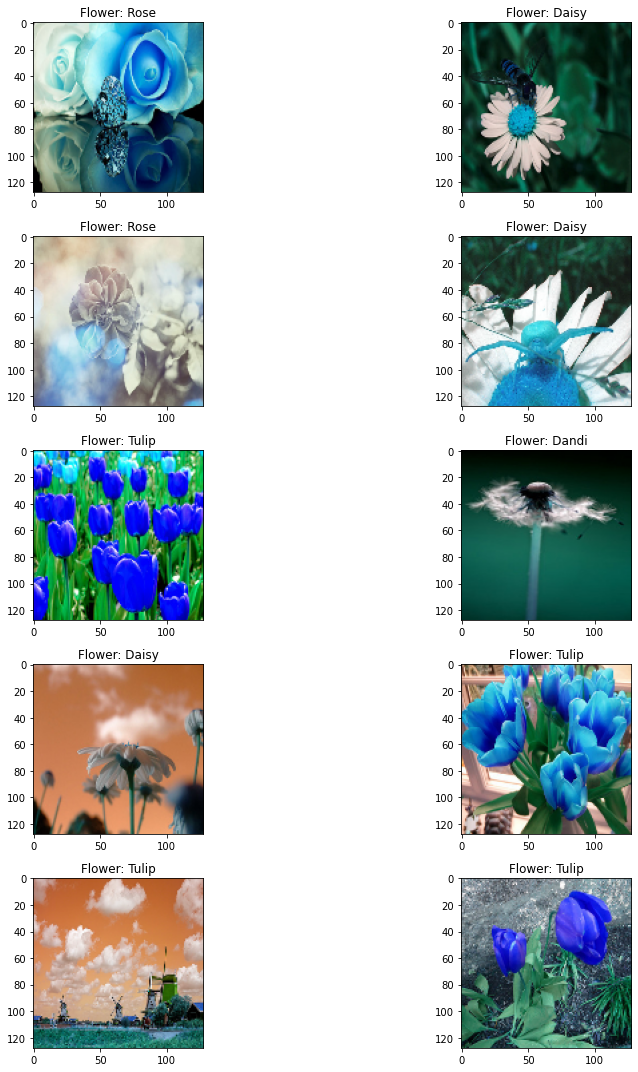

In [7]:
import matplotlib.pyplot as plot
import random

fig,ax=plot.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+labels[l])
        
plot.tight_layout()

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
transformed_labels = label_encoder.fit_transform(labels)

print(labels)
print(label_encoder.classes_)
np.save('label_encoder.npy', label_encoder.classes_)

Y = to_categorical(transformed_labels,5)
print(Y)

['Daisy' 'Daisy' 'Daisy' ... 'Rose' 'Rose' 'Rose']
['Daisy' 'Dandi' 'Rose' 'SunFlower' 'Tulip']
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [9]:
#split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

Modelling

In [10]:
import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
                        input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    keras.layers.Conv2D(filters=32, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=128, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
                  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

In [11]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=20)


Epoch 1/20
102/102 [==============================] - 4s 37ms/step - loss: 1.4209 - accuracy: 0.3751 - val_loss: 1.2964 - val_accuracy: 0.3941
Epoch 2/20
102/102 [==============================] - 3s 31ms/step - loss: 1.1829 - accuracy: 0.4975 - val_loss: 1.0876 - val_accuracy: 0.5384
Epoch 3/20
102/102 [==============================] - 3s 31ms/step - loss: 1.0439 - accuracy: 0.5805 - val_loss: 1.0885 - val_accuracy: 0.6189
Epoch 4/20
102/102 [==============================] - 3s 31ms/step - loss: 0.9016 - accuracy: 0.6444 - val_loss: 1.0755 - val_accuracy: 0.5615
Epoch 5/20
102/102 [==============================] - 3s 31ms/step - loss: 0.7597 - accuracy: 0.7088 - val_loss: 0.9879 - val_accuracy: 0.6383
Epoch 6/20
102/102 [==============================] - 3s 31ms/step - loss: 0.5892 - accuracy: 0.7795 - val_loss: 1.1223 - val_accuracy: 0.6142
Epoch 7/20
102/102 [==============================] - 3s 31ms/step - loss: 0.4160 - accuracy: 0.8575 - val_loss: 1.3059 - val_accuracy: 0.6401

In [12]:
model.history.history

{'loss': [1.4209257364273071,
  1.1828813552856445,
  1.0438746213912964,
  0.9016179442405701,
  0.7596822381019592,
  0.5891883969306946,
  0.4159896969795227,
  0.2633386254310608,
  0.22122347354888916,
  0.14040711522102356,
  0.08173482865095139,
  0.07434523105621338,
  0.08432697504758835,
  0.12740902602672577,
  0.07018690556287766,
  0.014431345276534557,
  0.017777152359485626,
  0.006784476339817047,
  0.0028831269592046738,
  0.00104401889257133],
 'accuracy': [0.37507709860801697,
  0.4975323975086212,
  0.5805058479309082,
  0.6443553566932678,
  0.708821713924408,
  0.779457151889801,
  0.8574953675270081,
  0.9164096117019653,
  0.9275138974189758,
  0.9537322521209717,
  0.9716224670410156,
  0.9784083962440491,
  0.9774830341339111,
  0.970388650894165,
  0.979333758354187,
  0.9962985515594482,
  0.9947563409805298,
  0.9987661838531494,
  0.9990746378898621,
  0.9996915459632874],
 'val_loss': [1.2964283227920532,
  1.0875811576843262,
  1.0884687900543213,
  1.07

In [13]:
import matplotlib.pyplot as plot
import pandas as pd

history = model.history.history
df = pd.DataFrame(history)
df

,loss,accuracy,val_loss,val_accuracy
0,1.420926,0.375077,1.296428,0.394080
1,1.182881,0.497532,1.087581,0.538390
2,1.043875,0.580506,1.088469,0.618871
3,0.901618,0.644355,1.075505,0.561517
4,0.759682,0.708822,0.987876,0.638298
5,0.589188,0.779457,1.122314,0.614246
6,0.415990,0.857495,1.305892,0.640148
7,0.263339,0.916410,1.828891,0.606845
8,0.221223,0.927514,2.328021,0.599445
9,0.140407,0.953732,2.547915,0.629972


<AxesSubplot:>

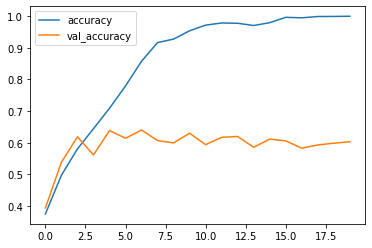

In [14]:
df[['accuracy', 'val_accuracy']].plot()

From the above image we can see, at the first epoches the accuracy and the validation accuracy rises at the same time. This process is underfitting. After that, the accuracy goes to very high but validation accuracy.
The main reason we got overfitting is we train the model by using same data, then the model catches too much details from training data. One way to avoid overfitting is transform data, like move, scale, and rotate.

In [15]:
del model

In [16]:
import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
                        input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    keras.layers.Conv2D(filters=32, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=128, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
                  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)      

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [18]:
batch_size = 32
epochs = 50
model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)


Epoch 1/50
101/101 [==============================] - 10s 103ms/step - loss: 1.3980 - accuracy: 0.3723 - val_loss: 1.1608 - val_accuracy: 0.4921
Epoch 2/50
101/101 [==============================] - 10s 96ms/step - loss: 1.1787 - accuracy: 0.4963 - val_loss: 1.0148 - val_accuracy: 0.6022
Epoch 3/50
101/101 [==============================] - 9s 84ms/step - loss: 1.0264 - accuracy: 0.5991 - val_loss: 0.9460 - val_accuracy: 0.6392
Epoch 4/50
101/101 [==============================] - 8s 83ms/step - loss: 0.9701 - accuracy: 0.6109 - val_loss: 0.9519 - val_accuracy: 0.6438
Epoch 5/50
101/101 [==============================] - 8s 83ms/step - loss: 0.9262 - accuracy: 0.6430 - val_loss: 0.9191 - val_accuracy: 0.6522
Epoch 6/50
101/101 [==============================] - 8s 83ms/step - loss: 0.9110 - accuracy: 0.6417 - val_loss: 0.8251 - val_accuracy: 0.6994
Epoch 7/50
101/101 [==============================] - 8s 82ms/step - loss: 0.8615 - accuracy: 0.6651 - val_loss: 0.8103 - val_accuracy: 0.6

In [19]:
history = model.history.history
df = pd.DataFrame(history)
df

,loss,accuracy,val_loss,val_accuracy
0,1.397951,0.372274,1.160798,0.492137
1,1.178742,0.496262,1.014793,0.602220
2,1.026400,0.599065,0.945985,0.639223
3,0.970115,0.610903,0.951925,0.643848
4,0.926198,0.642991,0.919063,0.652174
5,0.910990,0.641745,0.825141,0.699352
6,0.861458,0.665109,0.810306,0.699352
7,0.846013,0.671963,0.794854,0.698427
8,0.801511,0.684735,0.875375,0.646623
9,0.809959,0.685358,0.810720,0.691027


<AxesSubplot:>

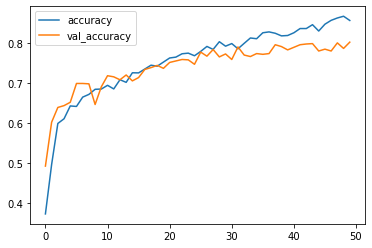

In [20]:
df[['accuracy', 'val_accuracy']].plot()

In [21]:
model.save('../deployment/model.h5')